# 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import get_linear_schedule_with_warmup

import time
import copy
import random
from tqdm import tqdm

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# import importlib

# libs = {
#     "pandas": "pd",
#     "numpy": "np",
#     "matplotlib": "matplotlib",
#     "seaborn": "sns",
#     "nltk": "nltk",
#     "sklearn": "sklearn",
#     "gensim": "gensim",
#     "iterstrat": "iterstrat",  # отдельно не имеет версии, берём из модуля
#     "torch": "torch",
#     "tqdm": "tqdm",
#     "transformers": "transformers",
# }

# # Получаем версии
# versions = {}
# for lib_name in libs:
#     try:
#         module = importlib.import_module(lib_name)
#         if lib_name == "iterstrat":
#             from iterstrat import ml_stratifiers
#             versions["iterstrat"] = ml_stratifiers.__version__
#         else:
#             versions[lib_name] = module.__version__
#     except Exception as e:
#         print(f"⚠️ Не удалось получить версию для {lib_name}: {e}")

# # Сохраняем в requirements.txt
# with open("requirements.txt", "w") as f:
#     for lib, ver in versions.items():
#         f.write(f"{lib}=={ver}\n")

# print("✅ Файл requirements.txt успешно создан.")

# # Показать ссылку на скачивание в Jupyter
# try:
#     from IPython.display import FileLink
#     display(FileLink('requirements.txt'))
# except:
#     pass


# 1. EDA

In [3]:
# Загрузка данных
df = pd.read_csv("train.csv") 

# Просмотр первых строк
print(df.head())

# Размерность таблицы
print("Всего строк:", len(df))

# Проверка на пропуски
print(df.isnull().sum())

# Удаление дубликатов
df = df.drop_duplicates(subset='text')
print("После удаления дубликатов:", len(df))

pd.set_option('display.max_colwidth', 1000)

   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]
Всего строк: 29568
id        0
text      0
labels    0
dtype: int64
После удаления дубликатов: 26967


Уникальных меток: 3508
TOP 10 меток по частоте:
[('1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0', 998), ('1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0', 723), ('0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0', 649), ('1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0', 479), ('0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0', 431), ('0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0', 400), ('0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0', 384), ('1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0', 384), ('1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0', 342), ('0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0', 297)]


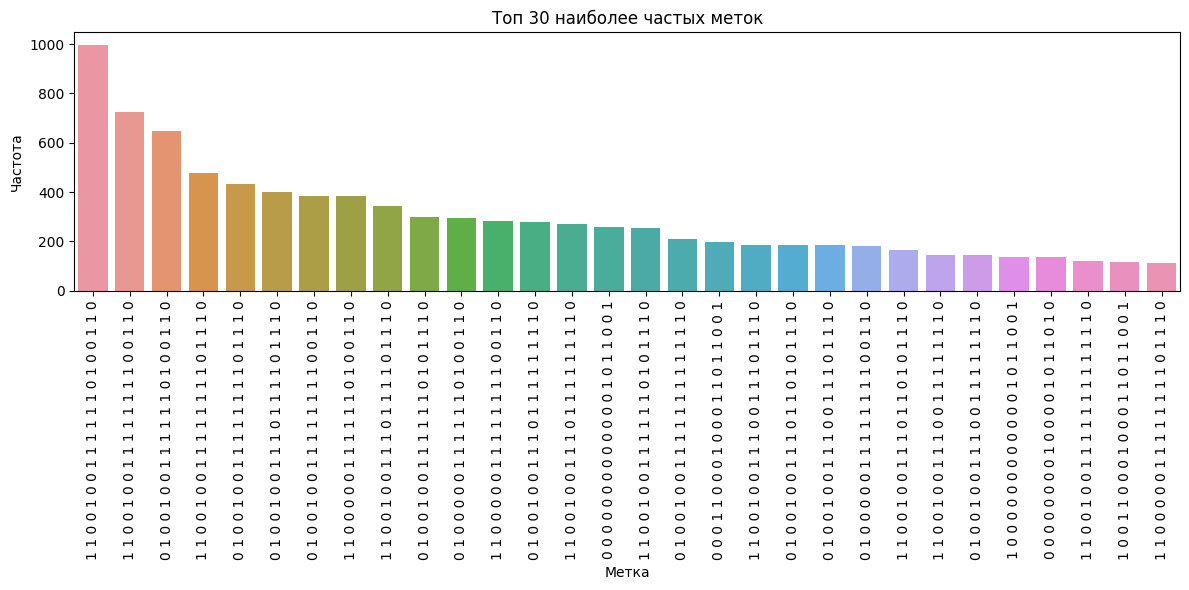

In [4]:
# Преобразуем строку меток в список меток
df['label_list'] = df['labels'].apply(lambda x: x.split(','))

# Подсчитаем общее количество уникальных меток
all_labels = [label for sublist in df['label_list'] for label in sublist]
label_counts = Counter(all_labels)

print("Уникальных меток:", len(label_counts))
print("TOP 10 меток по частоте:")
print(label_counts.most_common(10))

# Визуализация распределения частот меток
plt.figure(figsize=(12, 6))
top_n = 30
sns.barplot(x=[x[0] for x in label_counts.most_common(top_n)],
            y=[x[1] for x in label_counts.most_common(top_n)])
plt.xticks(rotation=90)
plt.title(f"Топ {top_n} наиболее частых меток")
plt.ylabel("Частота")
plt.xlabel("Метка")
plt.tight_layout()
plt.show()


In [5]:
# Создадим словарь: {метка: [тексты]}
label_to_texts = defaultdict(list)

for _, row in df.iterrows():
    for label in row['label_list']:
        if len(label_to_texts[label]) < 3:  # сохраняем до 3 примеров на метку
            label_to_texts[label].append(row['text'])

# Показать примеры для первых 5 меток
for label in list(label_to_texts.keys())[:5]:
    print(f"\n🔹 Метка: {label}")
    for i, example in enumerate(label_to_texts[label]):
        print(f"Пример {i+1}: {example[:200]}...")  # обрезаем до 200 символов



🔹 Метка: 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
Пример 1: 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532...
Пример 2: 20 октября
Лекторий: как не уснуть на экскурсии по городу?
Динара Веселова
19-00  бесплатно
❗
https://vk.com/ss_usptu
Первомайская 14
📍
регистрация обязательна...
Пример 3: 31 июля - 6 июля
Мероприятия на набережной реки Белой
19-09 бесплатно
❗️
https://vk.com/wall-220284138_78...

🔹 Метка: 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
Пример 1: 13 и 14 августа
Выходные в Меге
https://t.me/megaufa_official
Мегапарк...
Пример 2: 18 августа в парке
Танцевальный вечер
19-00
https://vk.com/ufa
Кашкадан...
Пример 3: 16-19 марта
Лекторий, кинопросмотр, книжный клуб в Кшиштоф
@krzysztofcoffee
Чернышевского 88
📍
запись обязательна
@ElisavetaKoroleva...

🔹 Метка: 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
Пример 1: Йокнапатофа
Постановка Театр им. Маяковского
Билеты от 500 до 2000 р....
Пример 2: 13 и 14 августа

# 2. Очистка

In [6]:
# Подгрузка ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Инициализация
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция очистки текста
def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # HTML
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    text = re.sub(r'[\d]', '', text)  # цифры
    text = text.translate(str.maketrans('', '', string.punctuation))  # пунктуация
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# ⏱ Засекаем время
start_time = time.time()

# Прогресс-бар через tqdm
tqdm.pandas(desc="🧼 Очистка текста (TF-IDF)")
df['clean_text_tfidf'] = df['text'].progress_apply(clean_text_tfidf)

# Время выполнения
end_time = time.time()
print(f"\n✅ Очистка завершена за {end_time - start_time:.2f} секунд")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
🧼 Очистка текста (TF-IDF): 100%|██████████| 26967/26967 [00:14<00:00, 1805.98it/s]


✅ Очистка завершена за 14.94 секунд


In [7]:
# Подгружаем ресурсы
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Настройки
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 👇 Функция очистки под Word2Vec
def clean_text_w2v(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)             
    text = re.sub(r'http\S+|www\S+', '', text)      
    text = re.sub(r'[\d]', '', text)               
    text = text.translate(str.maketrans('', '', string.punctuation))  
    tokens = nltk.word_tokenize(text)
    
    # Стоп-слова — по желанию: можно оставить, если они в словаре w2v
    tokens = [word for word in tokens if word not in stop_words]
    
    # Лемматизация
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens  # возвращаем список токенов, пригодится для обучения w2v

# Засекаем время
start_time = time.time()

# Прогресс-бар через tqdm
tqdm.pandas(desc="🧼 Очистка текста (Word2Vec)")
df['clean_tokens_w2v'] = df['text'].progress_apply(clean_text_w2v)

# Время выполнения
end_time = time.time()
print(f"\n✅ Очистка для Word2Vec завершена за {end_time - start_time:.2f} секунд")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
🧼 Очистка текста (Word2Vec): 100%|██████████| 26967/26967 [00:13<00:00, 1946.90it/s]


✅ Очистка для Word2Vec завершена за 13.85 секунд


In [8]:
# Подгружаем ресурсы
nltk.download('punkt')
nltk.download('wordnet')

# Инициализация
lemmatizer = WordNetLemmatizer()

# Очистка: возвращаем строку, пригодную для токенизации
def clean_text_cnn(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)              # HTML
    text = re.sub(r'http\S+|www\S+', '', text)     # ссылки
    text = re.sub(r'\d+', '', text)                # цифры
    text = text.translate(str.maketrans('', '', string.punctuation))  # пунктуация
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]        # опционально
    return ' '.join(tokens)  # нужна строка для токенизации

# Засекаем время
start_time = time.time()

# Прогресс-бар
tqdm.pandas(desc="🧼 Очистка текста (Embedding + CNN)")
df['clean_text_cnn'] = df['text'].progress_apply(clean_text_cnn)

# Время
end_time = time.time()
print(f"\n✅ Очистка для CNN завершена за {end_time - start_time:.2f} секунд")


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
🧼 Очистка текста (Embedding + CNN): 100%|██████████| 26967/26967 [00:13<00:00, 1933.46it/s]


✅ Очистка для CNN завершена за 13.95 секунд


In [9]:
# Подгружаем необходимые ресурсы
nltk.download('punkt')
nltk.download('wordnet')

# Инициализация
lemmatizer = WordNetLemmatizer()

# Очистка: возвращаем строку
def clean_text_rnn(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)              # HTML
    text = re.sub(r'http\S+|www\S+', '', text)     # ссылки
    text = re.sub(r'\d+', '', text)                # цифры
    text = text.translate(str.maketrans('', '', string.punctuation))  # пунктуация
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Засекаем время
start_time = time.time()

# Прогресс-бар
tqdm.pandas(desc="🧼 Очистка текста (Embedding + RNN)")
df['clean_text_rnn'] = df['text'].progress_apply(clean_text_rnn)

# Время выполнения
end_time = time.time()
print(f"\n✅ Очистка для RNN завершена за {end_time - start_time:.2f} секунд")


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
🧼 Очистка текста (Embedding + RNN): 100%|██████████| 26967/26967 [00:13<00:00, 1934.30it/s]


✅ Очистка для RNN завершена за 13.95 секунд


In [10]:
# Функция очистки для BERT-подобных моделей
def clean_text_bert(text):
    text = text.lower()  
    text = re.sub(r'<.*?>', '', text)             
    text = re.sub(r'http\S+|www\S+', '', text)    
    # Не удаляем цифры и пунктуацию
    return text.strip()

# Засекаем время
start_time = time.time()

# Прогресс-бар
tqdm.pandas(desc="🧼 Очистка текста (BERT)")
df['clean_text_bert'] = df['text'].progress_apply(clean_text_bert)

# Время
end_time = time.time()
print(f"\n✅ Очистка для BERT завершена за {end_time - start_time:.2f} секунд")

🧼 Очистка текста (BERT): 100%|██████████| 26967/26967 [00:00<00:00, 105368.78it/s]


✅ Очистка для BERT завершена за 0.26 секунд


# 3. Обучение

In [11]:
# %pip install iterstrat

In [12]:
# pip install iterative-stratification

In [13]:
# %pip install git+https://github.com/trent-b/iterative-stratification.git

In [14]:
# 1) Преобразуем строку с метками в список из int
def labels_str_to_list(s):
    return list(map(int, s.split()))

df['labels_list'] = df['labels'].apply(labels_str_to_list)

# 2) Создаем бинарную матрицу из списков (shape = [n_samples, 20])
labels_matrix = np.array(df['labels_list'].to_list())

# 3) Стратифицированное разделение
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, valid_idx = next(mskf.split(df, labels_matrix))

train_df = df.iloc[train_idx].reset_index(drop=True)
valid_df = df.iloc[valid_idx].reset_index(drop=True)

# Проверяем распределение меток
print("Train labels distribution:\n", train_df['labels_list'].apply(sum).value_counts())
print("Valid labels distribution:\n", valid_df['labels_list'].apply(sum).value_counts())

print(f"Train size: {len(train_df)}; Valid size: {len(valid_df)}")


Train labels distribution:
 12    4485
11    4160
13    2927
10    2884
9     2107
8     1608
14    1139
7      907
6      577
5      438
4      210
15     127
16       4
Name: labels_list, dtype: int64
Valid labels distribution:
 12    1149
11    1013
10     747
13     745
9      522
8      369
14     272
7      222
6      154
5      113
4       53
15      33
16       2
Name: labels_list, dtype: int64
Train size: 21573; Valid size: 5394


In [15]:
# Преобразуем строку с метками в список из int ===
def labels_str_to_list(s):
    return list(map(int, s.split()))

df['labels_list'] = df['labels'].apply(labels_str_to_list)

# Преобразуем список меток в бинарную матрицу (numpy array) ===
labels_matrix = np.array(df['labels_list'].to_list())

# Создаем объект для мульти-лейбл стратифицированного сплита ===
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Получаем индексы первого разбиения train/valid ===
train_idx, valid_idx = next(mskf.split(df, labels_matrix))

# Формируем train и valid DataFrame ===
train_df = df.iloc[train_idx].reset_index(drop=True)
valid_df = df.iloc[valid_idx].reset_index(drop=True)


X_train = train_df['text'].values
y_train = np.array(train_df['labels_list'].to_list())

X_valid = valid_df['text'].values
y_valid = np.array(valid_df['labels_list'].to_list())


# Анализ распределения по меткам в train/valid ===
train_labels_df = pd.DataFrame(train_df['labels_list'].to_list(), columns=[f'label_{i}' for i in range(labels_matrix.shape[1])])
valid_labels_df = pd.DataFrame(valid_df['labels_list'].to_list(), columns=[f'label_{i}' for i in range(labels_matrix.shape[1])])

train_label_counts = train_labels_df.sum(axis=0)
valid_label_counts = valid_labels_df.sum(axis=0)

print("Train label counts (по каждой метке):")
print(train_label_counts)

print("\nValid label counts (по каждой метке):")
print(valid_label_counts)

print(f"\nTrain size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")


Train label counts (по каждой метке):
label_0     11699
label_1     13954
label_2      1085
label_3      1294
label_4     13264
label_5        77
label_6       154
label_7     16634
label_8     16974
label_9     15024
label_10     9327
label_11    13548
label_12    17073
label_13    16767
label_14    16340
label_15    10806
label_16    15928
label_17    17175
label_18    17748
label_19     4183
dtype: int64

Valid label counts (по каждой метке):
label_0     2925
label_1     3488
label_2      271
label_3      324
label_4     3316
label_5       19
label_6       38
label_7     4146
label_8     4213
label_9     3741
label_10    2311
label_11    3400
label_12    4260
label_13    4191
label_14    4151
label_15    2702
label_16    3982
label_17    4366
label_18    4437
label_19    1045
dtype: int64

Train size: 21573
Valid size: 5394


In [16]:
def train_model(
    model,
    train_loader,
    valid_loader,
    criterion_dict,     
    metric_dict,        
    optimizer,
    scheduler,
    device,
    num_epochs=20,
    switch_epoch=None,  
    save_path='best_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses, valid_losses = [], []
    train_metrics, valid_metrics = [], []

    global_step = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Если есть переключение лоссов/метрик
        if switch_epoch and epoch == switch_epoch:
            criterion_train = criterion_dict['valid']
            criterion_valid = criterion_dict['valid']
            metric_train = metric_dict['valid']
            metric_valid = metric_dict['valid']
            print("Switched loss and metric function at epoch", epoch+1)
        else:
            criterion_train = criterion_dict['train']
            criterion_valid = criterion_dict['valid']
            metric_train = metric_dict['train']
            metric_valid = metric_dict['valid']

        # --- Тренировочная фаза ---
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for batch_idx, batch in enumerate(train_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion_train(outputs, targets)
            loss.backward()

            # Warmup lr scheduler (если есть)
            if warmup_steps > 0 and global_step < warmup_steps:
                lr_scale = min(1., float(global_step + 1) / warmup_steps)
                for pg in optimizer.param_groups:
                    pg['lr'] = lr_scale * pg['initial_lr']

            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            # Сохраняем предсказания и цели для метрик
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()

            all_preds.append(preds)
            all_targets.append(targets_np)

            global_step += 1

           
        epoch_loss = running_loss / len(train_loader.dataset)

        all_preds_np = np.vstack(all_preds)
        all_targets_np = np.vstack(all_targets)

        # Функция метрики принимает y_true, y_pred бинарные
        epoch_metric = metric_train(all_targets_np, (all_preds_np > 0.5).astype(int))

        train_losses.append(epoch_loss)
        train_metrics.append(epoch_metric)

        print(f'Train Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

        # --- Валидационная фаза ---
        model.eval()
        running_loss = 0.0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for batch in valid_loader:
                inputs = batch['input'].to(device)
                targets = batch['target'].to(device)

                outputs = model(inputs)

                loss = criterion_valid(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).cpu().numpy()
                targets_np = targets.cpu().numpy()

                all_preds.append(preds)
                all_targets.append(targets_np)

        epoch_loss = running_loss / len(valid_loader.dataset)
        all_preds_np = np.vstack(all_preds)
        all_targets_np = np.vstack(all_targets)
        epoch_metric = metric_valid(all_targets_np, (all_preds_np > 0.5).astype(int))

        valid_losses.append(epoch_loss)
        valid_metrics.append(epoch_metric)

        print(f'Valid Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

        # Шедулер (обычно StepLR или ReduceLROnPlateau)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()

        # Сохраняем лучшую модель по валидационному лоссу
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {epoch_loss:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Ранняя остановка
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Загружаем лучшую модель
    model.load_state_dict(best_model_wts)

    # --- Графики ---
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_metrics, label='Train Metric')
    plt.plot(epochs_range, valid_metrics, label='Valid Metric')
    plt.xlabel('Epoch')
    plt.ylabel('Metric (F1)')
    plt.legend()
    plt.grid()

    plt.show()

    return model


In [17]:
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")  
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

device = get_device()

Using device: cuda


Epoch 1/20
--------------------
Train Loss: 0.3380 Metric: 0.8653
Valid Loss: 0.2426 Metric: 0.9040
Saved best model at epoch 1 with val loss 0.2426

Epoch 2/20
--------------------
Train Loss: 0.2103 Metric: 0.9177
Valid Loss: 0.2058 Metric: 0.9177
Saved best model at epoch 2 with val loss 0.2058

Epoch 3/20
--------------------
Train Loss: 0.1711 Metric: 0.9346
Valid Loss: 0.1910 Metric: 0.9228
Saved best model at epoch 3 with val loss 0.1910

Epoch 4/20
--------------------
Train Loss: 0.1456 Metric: 0.9456
Valid Loss: 0.1847 Metric: 0.9259
Saved best model at epoch 4 with val loss 0.1847

Epoch 5/20
--------------------
Train Loss: 0.1256 Metric: 0.9539
Valid Loss: 0.1852 Metric: 0.9267

Epoch 6/20
--------------------
Train Loss: 0.1104 Metric: 0.9601
Valid Loss: 0.1863 Metric: 0.9271

Epoch 7/20
--------------------
Train Loss: 0.0979 Metric: 0.9660
Valid Loss: 0.1900 Metric: 0.9270
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Early stopping triggered after 7 epo

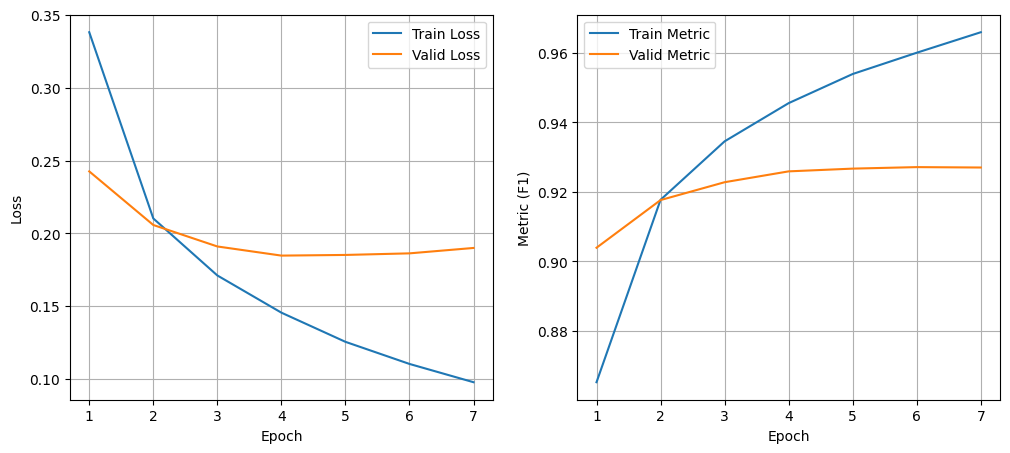

In [18]:
# 1. Подготовка TF-IDF признаков

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')

# Обучаем TF-IDF на всех тренировочных текстах
tfidf.fit(train_df['text'])

X_train_tfidf = tfidf.transform(train_df['text'])  
X_valid_tfidf = tfidf.transform(valid_df['text'])

# Метки
y_train = np.array(train_df['labels_list'].to_list(), dtype=np.float32)
y_valid = np.array(valid_df['labels_list'].to_list(), dtype=np.float32)

# 2. Dataset и DataLoader для PyTorch

class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze()  
        y = self.y[idx]
        return {
            'input': torch.tensor(x, dtype=torch.float32),
            'target': torch.tensor(y, dtype=torch.float32)
        }

train_dataset = TfidfDataset(X_train_tfidf, y_train)
valid_dataset = TfidfDataset(X_valid_tfidf, y_valid)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

# 3. Простая нейронная сеть для TF-IDF (2 слоя)

class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNN(input_dim=X_train_tfidf.shape[1]).to(device)

# 4. Лосс и метрика

criterion_dict = {
    'train': nn.BCEWithLogitsLoss(),
    'valid': nn.BCEWithLogitsLoss()
}

def f1_score_multilabel(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

metric_dict = {
    'train': f1_score_multilabel,
    'valid': f1_score_multilabel
}

# 5. Оптимайзер и шедулер

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# 6. Запуск обучения

model = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion_dict=criterion_dict,
    metric_dict=metric_dict,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    switch_epoch=None,
    save_path='best_tfidf_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
)


In [19]:
# import pandas as pd
# import torch

# # 1. Загружаем тестовый датасет
# test_df = pd.read_csv('test.csv')

# # 2. Очистка текста (если у тебя была своя функция очистки, применим её)
# # Пример простой очистки, если ты использовал свою функцию, замени её:
# def clean_text(text):
#     # тут можешь поставить свою логику очистки из пайплайна для tf-idf
#     return text.lower()

# test_df['text_clean'] = test_df['text'].apply(clean_text)

# # 3. Преобразуем в TF-IDF признаки
# X_test_tfidf = tfidf.transform(test_df['text_clean'])

# # 4. Превращаем в DataLoader для батчевой обработки

# class TestTfidfDataset(Dataset):
#     def __init__(self, X):
#         self.X = X

#     def __len__(self):
#         return self.X.shape[0]

#     def __getitem__(self, idx):
#         x = self.X[idx].toarray().squeeze()
#         return torch.tensor(x, dtype=torch.float32)

# test_dataset = TestTfidfDataset(X_test_tfidf)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# # 5. Предсказания (без градиентов, модель в eval режиме)

# model.eval()
# all_preds = []

# with torch.no_grad():
#     for batch in test_loader:
#         inputs = batch.to(device)
#         outputs = model(inputs)
#         probs = torch.sigmoid(outputs).cpu().numpy()
#         all_preds.append(probs)

# all_preds = np.vstack(all_preds)  # shape (n_samples, n_classes)

# # 6. Бинаризация с порогом 0.5

# all_preds_bin = (all_preds > 0.5).astype(int)

# # 7. Формируем колонку labels в формате строки '0 1 0 1 ...'

# labels_str = [' '.join(map(str, row)) for row in all_preds_bin]

# # 8. Формируем submission DataFrame

# submission = pd.DataFrame({
#     'id': test_df['id'],
#     'labels': labels_str
# })

# # 9. Сохраняем в CSV

# submission.to_csv('submission_new.csv', index=False)


In [20]:
# submission.head()

Epoch 1/20
--------------------
Train Loss: 0.6898 Metric: 0.5901
Valid Loss: 0.6890 Metric: 0.5933
Saved best model at epoch 1 with val loss 0.6890

Epoch 2/20
--------------------
Train Loss: 0.6898 Metric: 0.5893
Valid Loss: 0.6890 Metric: 0.5933

Epoch 3/20
--------------------
Train Loss: 0.6898 Metric: 0.5892
Valid Loss: 0.6890 Metric: 0.5933
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.

Epoch 4/20
--------------------
Train Loss: 0.6899 Metric: 0.5890
Valid Loss: 0.6890 Metric: 0.5933
Early stopping triggered after 4 epochs
Training complete in 0m 19s
Best val loss: 0.6890


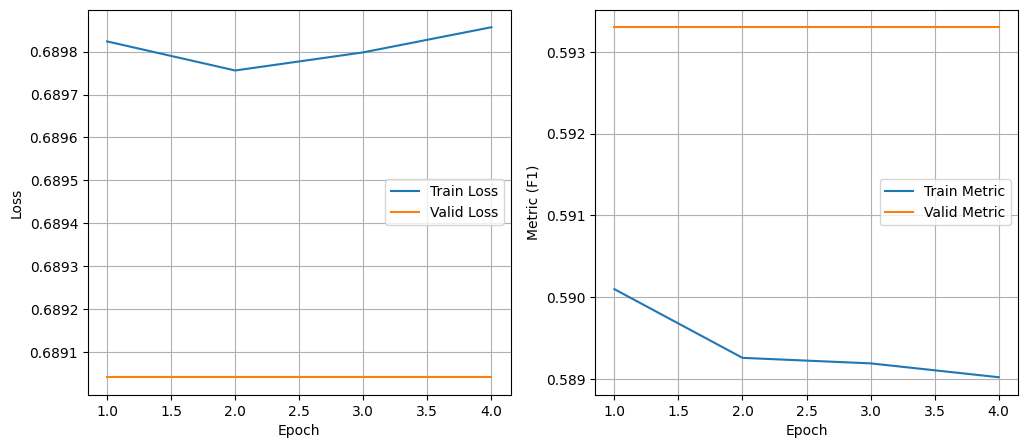

In [21]:
train_df['tokens'] = train_df['clean_tokens_w2v']
valid_df['tokens'] = valid_df['clean_tokens_w2v']
# Обучаем Word2Vec на токенах (можно подставить параметры)
w2v_model = Word2Vec(sentences=train_df['tokens'], vector_size=100, window=5, min_count=2, workers=4, epochs=10)

# Функция для преобразования текста в средний вектор

def text_to_w2v_avg(tokens, model, vector_size=100):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Создаем датасет с w2v эмбеддингами

class W2VDataset(Dataset):
    def __init__(self, tokens_list, labels, w2v_model, vector_size=100):
        self.tokens_list = tokens_list
        self.labels = labels
        self.w2v_model = w2v_model
        self.vector_size = vector_size

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        label = self.labels[idx]
        vector = text_to_w2v_avg(tokens, self.w2v_model, self.vector_size)
        # Возвращаем словарь с ключами 'input' и 'target'
        return {'input': torch.tensor(vector, dtype=torch.float32), 'target': torch.tensor(label, dtype=torch.float32)}


# Создаем train и valid датасеты и загрузчики

train_dataset = W2VDataset(
    tokens_list=train_df['tokens'].values,
    labels=y_train,
    w2v_model=w2v_model,
    vector_size=w2v_model.vector_size
)
valid_dataset = W2VDataset(
    tokens_list=valid_df['tokens'].values,
    labels=y_valid,
    w2v_model=w2v_model,
    vector_size=w2v_model.vector_size
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

# Определяем простую нейросеть 

class W2VNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

model_w = W2VNet(input_dim=w2v_model.vector_size, output_dim=y_train.shape[1])
model_w.to(device)

# Обучаем модель с использованием твоей обучающей функции

model_w2v = train_model(
    model=model_w,
    train_loader=train_loader,       
    valid_loader=valid_loader,
    criterion_dict=criterion_dict,
    metric_dict=metric_dict,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    switch_epoch=None,               
    save_path='best_w2v_model.pth', 
    early_stopping_patience=3,
    warmup_steps=0
)


Epoch 1/20
--------------------
Train Loss: 0.3942 Metric: 0.8329
Valid Loss: 0.3015 Metric: 0.8793
Saved best model at epoch 1 with val loss 0.3015

Epoch 2/20
--------------------
Train Loss: 0.3127 Metric: 0.8708
Valid Loss: 0.2753 Metric: 0.8898
Saved best model at epoch 2 with val loss 0.2753

Epoch 3/20
--------------------
Train Loss: 0.2858 Metric: 0.8827
Valid Loss: 0.2594 Metric: 0.8948
Saved best model at epoch 3 with val loss 0.2594

Epoch 4/20
--------------------
Train Loss: 0.2673 Metric: 0.8910
Valid Loss: 0.2513 Metric: 0.8994
Saved best model at epoch 4 with val loss 0.2513

Epoch 5/20
--------------------
Train Loss: 0.2502 Metric: 0.8985
Valid Loss: 0.2452 Metric: 0.9022
Saved best model at epoch 5 with val loss 0.2452

Epoch 6/20
--------------------
Train Loss: 0.2367 Metric: 0.9039
Valid Loss: 0.2394 Metric: 0.9042
Saved best model at epoch 6 with val loss 0.2394

Epoch 7/20
--------------------
Train Loss: 0.2234 Metric: 0.9105
Valid Loss: 0.2364 Metric: 0.9062


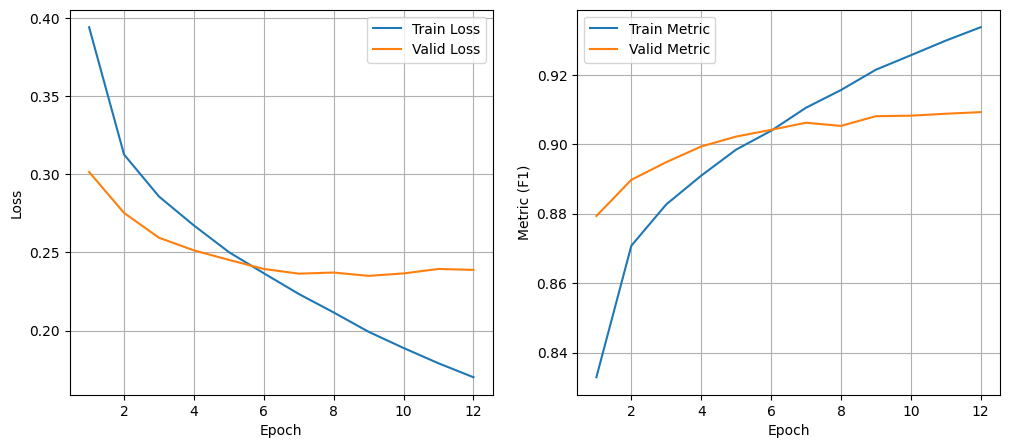

In [22]:
# 1. Построение словаря
def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = word_tokenize(clean_text_cnn(text))
        counter.update(tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# 2. Токенизация и индексация
def encode_text(text, vocab, max_len=100):
    tokens = word_tokenize(clean_text_cnn(text))
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(ids) < max_len:
        ids += [vocab['<PAD>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

# 3. Dataset
class TextDataset(Dataset):
    def __init__(self, texts, targets, vocab, max_len=100):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode_text(self.texts[idx], self.vocab, self.max_len)
        y = self.targets[idx]
        return {
            'input': torch.tensor(x, dtype=torch.long),
            'target': torch.tensor(y, dtype=torch.float32)
        }

# 4. CNN модель
class CNNText(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)         # (B, L, D)
        x = x.permute(0, 2, 1)        # (B, D, L)
        convs = [torch.relu(conv(x)) for conv in self.convs]
        pools = [torch.max(c, dim=2)[0] for c in convs]
        x = torch.cat(pools, dim=1)
        x = self.dropout(x)
        return self.fc(x)

# 5. Подготовка данных
vocab = build_vocab(train_df['text'])
y_train = np.array(train_df['labels_list'].to_list(), dtype=np.float32)
y_valid = np.array(valid_df['labels_list'].to_list(), dtype=np.float32)

train_dataset = TextDataset(train_df['text'].tolist(), y_train, vocab, max_len=100)
valid_dataset = TextDataset(valid_df['text'].tolist(), y_valid, vocab, max_len=100)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

# 6. Модель, лосс, метрика
model_cnn = CNNText(vocab_size=len(vocab), embed_dim=128, num_classes=y_train.shape[1]).to(device)

criterion_dict = {
    'train': nn.BCEWithLogitsLoss(),
    'valid': nn.BCEWithLogitsLoss()
}

def f1_score_multilabel(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

metric_dict = {
    'train': f1_score_multilabel,
    'valid': f1_score_multilabel
}

# 7. Оптимайзер и шедулер
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# 8. Запуск обучения
model_cnn = train_model(
    model=model_cnn,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion_dict=criterion_dict,
    metric_dict=metric_dict,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    switch_epoch=None,
    save_path='best_cnn_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
)


In [23]:
# import pandas as pd
# import torch
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# device = torch.device("cpu")
# # 1. Загружаем тестовый датасет
# test_df = pd.read_csv('test.csv')

# # 2. Очищаем текст с помощью clean_text_cnn (из твоего кода)
# test_df['clean_text_cnn'] = test_df['text'].progress_apply(clean_text_cnn)

# # 3. Кодируем текст в последовательности индексов
# test_indices = [encode_text(text, vocab, max_len=100) for text in test_df['clean_text_cnn']]

# # 4. Создаем Dataset для теста
# class TestCnnDataset(Dataset):
#     def __init__(self, indices_list):
#         self.indices_list = indices_list

#     def __len__(self):
#         return len(self.indices_list)

#     def __getitem__(self, idx):
#         return torch.tensor(self.indices_list[idx], dtype=torch.long)

# test_dataset = TestCnnDataset(test_indices)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # 5. Предсказание модели (eval режим, без градиентов)
# model_cnn.eval()
# all_preds = []

# with torch.no_grad():
#     for batch in test_loader:
#         batch = batch.to(device)          # (batch_size, seq_len)
#         outputs = model_cnn(batch)        # (batch_size, num_classes)
#         probs = torch.sigmoid(outputs).cpu().numpy()
#         all_preds.append(probs)

# all_preds = np.vstack(all_preds)         # (num_samples, num_classes)

# # 6. Бинаризация с порогом 0.5
# all_preds_bin = (all_preds > 0.5).astype(int)

# # 7. Формируем строку с метками '0 1 0 0 ...'
# labels_str = [' '.join(map(str, row)) for row in all_preds_bin]

# # 8. Формируем DataFrame для сабмита
# submission = pd.DataFrame({
#     'id': test_df['id'],
#     'labels': labels_str
# })

# # 9. Сохраняем результат
# submission.to_csv('submission_cnn.csv', index=False)


Epoch 1/20
--------------------
Train Loss: 0.3662 Metric: 0.8410
Valid Loss: 0.3217 Metric: 0.8621
Saved best model at epoch 1 with val loss 0.3217

Epoch 2/20
--------------------
Train Loss: 0.3123 Metric: 0.8647
Valid Loss: 0.2970 Metric: 0.8618
Saved best model at epoch 2 with val loss 0.2970

Epoch 3/20
--------------------
Train Loss: 0.2891 Metric: 0.8766
Valid Loss: 0.2792 Metric: 0.8806
Saved best model at epoch 3 with val loss 0.2792

Epoch 4/20
--------------------
Train Loss: 0.2712 Metric: 0.8852
Valid Loss: 0.2677 Metric: 0.8879
Saved best model at epoch 4 with val loss 0.2677

Epoch 5/20
--------------------
Train Loss: 0.2559 Metric: 0.8931
Valid Loss: 0.2588 Metric: 0.8931
Saved best model at epoch 5 with val loss 0.2588

Epoch 6/20
--------------------
Train Loss: 0.2406 Metric: 0.9020
Valid Loss: 0.2482 Metric: 0.8992
Saved best model at epoch 6 with val loss 0.2482

Epoch 7/20
--------------------
Train Loss: 0.2251 Metric: 0.9098
Valid Loss: 0.2440 Metric: 0.9025


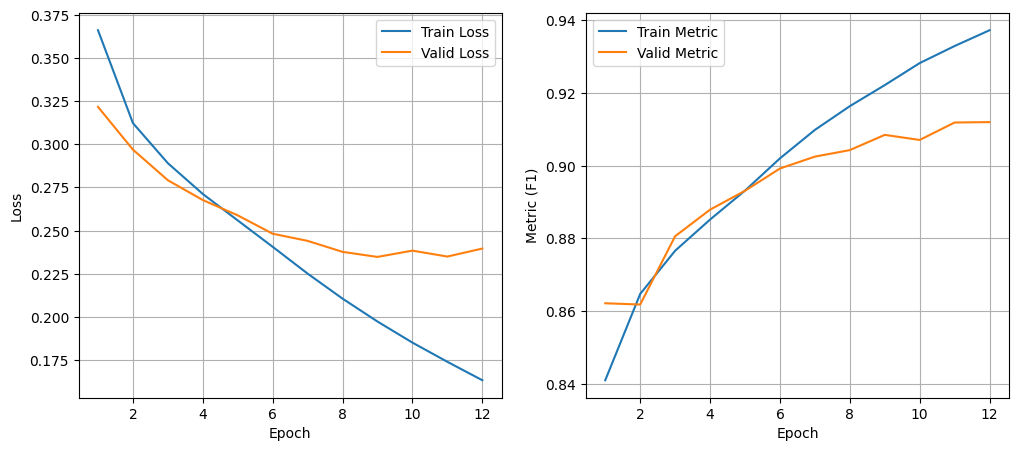

In [24]:
# 1. Построение словаря
def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = word_tokenize(clean_text_cnn(text))
        counter.update(tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# 2. Токенизация и индексация
def encode_text(text, vocab, max_len=100):
    tokens = word_tokenize(clean_text_cnn(text))
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(ids) < max_len:
        ids += [vocab['<PAD>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

# 3. Dataset
class TextDataset(Dataset):
    def __init__(self, texts, targets, vocab, max_len=100):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode_text(self.texts[idx], self.vocab, self.max_len)
        y = self.targets[idx]
        return {
            'input': torch.tensor(x, dtype=torch.long),
            'target': torch.tensor(y, dtype=torch.float32)
        }

# 4. RNN (LSTM) модель
class RNNText(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (B, L, D)
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]  # последний слой, последний временной шаг (B, H)
        out = self.dropout(last_hidden)
        out = self.fc(out)  # (B, num_classes)
        return out

# 5. Подготовка данных
vocab = build_vocab(train_df['text'])
y_train = np.array(train_df['labels_list'].to_list(), dtype=np.float32)
y_valid = np.array(valid_df['labels_list'].to_list(), dtype=np.float32)

train_dataset = TextDataset(train_df['text'].tolist(), y_train, vocab, max_len=100)
valid_dataset = TextDataset(valid_df['text'].tolist(), y_valid, vocab, max_len=100)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

# 6. Модель, лосс, метрика

model_rnn = RNNText(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=256,
    num_layers=2,
    num_classes=y_train.shape[1],
    dropout=0.5
).to(device)

criterion_dict = {
    'train': nn.BCEWithLogitsLoss(),
    'valid': nn.BCEWithLogitsLoss()
}

def f1_score_multilabel(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

metric_dict = {
    'train': f1_score_multilabel,
    'valid': f1_score_multilabel
}

# 7. Оптимайзер и шедулер
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# 8. Запуск обучения
model_rnn = train_model(
    model=model_rnn,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion_dict=criterion_dict,
    metric_dict=metric_dict,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    switch_epoch=None,
    save_path='best_rnn_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
)


In [25]:
# pip install transformers
# %pip install transformers==4.36.2

In [26]:
# --- Dataset ---
class TinyBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'target': torch.tensor(label, dtype=torch.float32)
        }

# --- Модель ---
class TinyBertForMultiLabel(nn.Module):
    def __init__(self, model_name='prajjwal1/bert-tiny', num_labels=20):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

# --- Метрика ---
def f1_score_multilabel(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

# --- Обучение ---
def train_model(
    model,
    train_loader,
    valid_loader,
    criterion_dict,
    metric_dict,
    optimizer,
    scheduler,
    device,
    num_epochs=20,
    switch_epoch=None,
    save_path='best_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses, valid_losses = [], []
    train_metrics, valid_metrics = [], []

    global_step = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        if switch_epoch and epoch == switch_epoch:
            criterion_train = criterion_dict['valid']
            criterion_valid = criterion_dict['valid']
            metric_train = metric_dict['valid']
            metric_valid = metric_dict['valid']
            print("Switched loss and metric function at epoch", epoch+1)
        else:
            criterion_train = criterion_dict['train']
            criterion_valid = criterion_dict['valid']
            metric_train = metric_dict['train']
            metric_valid = metric_dict['valid']

        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion_train(outputs, targets)
            loss.backward()

            if warmup_steps > 0 and global_step < warmup_steps:
                lr_scale = min(1., float(global_step + 1) / warmup_steps)
                for pg in optimizer.param_groups:
                    pg['lr'] = lr_scale * pg['initial_lr']

            optimizer.step()
            running_loss += loss.item() * input_ids.size(0)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()

            all_preds.append(preds)
            all_targets.append(targets_np)

            global_step += 1

        epoch_loss = running_loss / len(train_loader.dataset)
        all_preds_np = np.vstack(all_preds)
        all_targets_np = np.vstack(all_targets)
        epoch_metric = metric_train(all_targets_np, (all_preds_np > 0.5).astype(int))

        train_losses.append(epoch_loss)
        train_metrics.append(epoch_metric)

        print(f'Train Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

        # --- VALIDATION ---
        model.eval()
        running_loss = 0.0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['target'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion_valid(outputs, targets)
                running_loss += loss.item() * input_ids.size(0)

                preds = torch.sigmoid(outputs).cpu().numpy()
                targets_np = targets.cpu().numpy()

                all_preds.append(preds)
                all_targets.append(targets_np)

        epoch_loss = running_loss / len(valid_loader.dataset)
        all_preds_np = np.vstack(all_preds)
        all_targets_np = np.vstack(all_targets)
        epoch_metric = metric_valid(all_targets_np, (all_preds_np > 0.5).astype(int))

        valid_losses.append(epoch_loss)
        valid_metrics.append(epoch_metric)

        print(f'Valid Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {epoch_loss:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)

    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_metrics, label='Train Metric')
    plt.plot(epochs_range, valid_metrics, label='Valid Metric')
    plt.xlabel('Epoch')
    plt.ylabel('Metric (F1)')
    plt.legend()
    plt.grid()

    plt.show()

    return model


/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/10
--------------------
Train Loss: 0.4505 Metric: 0.8165
Valid Loss: 0.4101 Metric: 0.8335
Saved best model at epoch 1 with val loss 0.4101

Epoch 2/10
--------------------
Train Loss: 0.4044 Metric: 0.8325
Valid Loss: 0.3937 Metric: 0.8379
Saved best model at epoch 2 with val loss 0.3937

Epoch 3/10
--------------------
Train Loss: 0.3910 Metric: 0.8364
Valid Loss: 0.3848 Metric: 0.8369
Saved best model at epoch 3 with val loss 0.3848

Epoch 4/10
--------------------
Train Loss: 0.3814 Metric: 0.8400
Valid Loss: 0.3814 Metric: 0.8420
Saved best model at epoch 4 with val loss 0.3814

Epoch 5/10
--------------------
Train Loss: 0.3742 Metric: 0.8426
Valid Loss: 0.3747 Metric: 0.8421
Saved best model at epoch 5 with val loss 0.3747

Epoch 6/10
--------------------
Train Loss: 0.3687 Metric: 0.8449
Valid Loss: 0.3702 Metric: 0.8447
Saved best model at epoch 6 with val loss 0.3702

Epoch 7/10
--------------------
Train Loss: 0.3640 Metric: 0.8465
Valid Loss: 0.3680 Metric: 0.8427


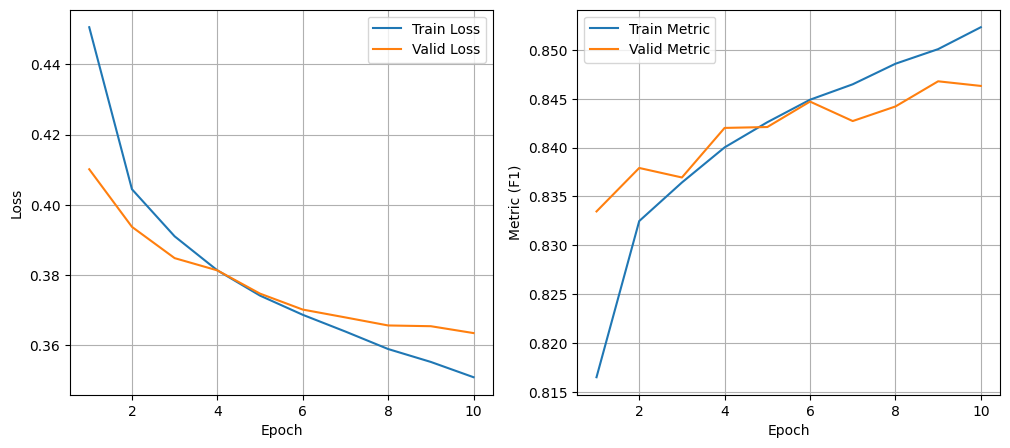

In [27]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_texts = train_df['text'].tolist()
valid_texts = valid_df['text'].tolist()

y_train = np.array(train_df['labels_list'].to_list(), dtype=np.float32)
y_valid = np.array(valid_df['labels_list'].to_list(), dtype=np.float32)

train_dataset = TinyBertDataset(train_texts, y_train, tokenizer, max_len=64)
valid_dataset = TinyBertDataset(valid_texts, y_valid, tokenizer, max_len=64)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

model = TinyBertForMultiLabel(model_name=MODEL_NAME, num_labels=y_train.shape[1]).to(device)

criterion_dict = {
    'train': nn.BCEWithLogitsLoss(),
    'valid': nn.BCEWithLogitsLoss()
}

metric_dict = {
    'train': f1_score_multilabel,
    'valid': f1_score_multilabel
}

optimizer = AdamW(model.parameters(), lr=4e-5)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

model = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion_dict=criterion_dict,
    metric_dict=metric_dict,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    save_path='best_tinybert_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
)


In [28]:
# import pandas as pd
# import torch
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoTokenizer

# # 1. Настройки
# MODEL_NAME = 'prajjwal1/bert-tiny'
# NUM_LABELS = 20  # у тебя 20 меток

# # 2. Загружаем токенизатор
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# # 3. Переводим модель в eval и на устройство
# model.to(device)
# model.eval()

# # 4. Загрузка и очистка тестового датафрейма
# test_df = pd.read_csv('test.csv')

# def clean_text(text):
#     return text.lower()  # если у тебя была другая очистка — замени

# test_df['text_clean'] = test_df['text'].apply(clean_text)

# # 5. Dataset
# class BertTestDataset(Dataset):
#     def __init__(self, texts, tokenizer, max_len=128):
#         self.texts = texts
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         encoding = self.tokenizer(
#             self.texts[idx],
#             truncation=True,
#             padding='max_length',
#             max_length=self.max_len,
#             return_tensors='pt'
#         )
#         return {
#             'input_ids': encoding['input_ids'].squeeze(0),
#             'attention_mask': encoding['attention_mask'].squeeze(0)
#         }

# test_dataset = BertTestDataset(test_df['text_clean'].tolist(), tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # 6. Инференс
# all_preds = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         probs = torch.sigmoid(outputs).cpu().numpy()
#         all_preds.append(probs)

# all_preds = np.vstack(all_preds)  # (n_samples, 20)

# # 7. Бинаризация
# all_preds_bin = (all_preds > 0.5).astype(int)

# # 8. Формирование строки с метками
# labels_str = [' '.join(map(str, row)) for row in all_preds_bin]

# # 9. Сбор submission
# submission = pd.DataFrame({
#     'id': test_df['id'],
#     'labels': labels_str
# })

# submission.to_csv('submission_bert.csv', index=False)


In [29]:
# submission.head()

# 4. Генератор

In [30]:
# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Имя модели
MODEL_NAME = "sberbank-ai/rugpt3small_based_on_gpt2"

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

# Обработка пад токена
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Примеры из датафрейма df
examples = df.sample(3, random_state=42)[['text', 'labels']].values.tolist()

# Формирование prompt
prompt = (
    "Пожалуйста, сгенерируй связанный, читабельный текст на русском языке, "
    "избегая бессмысленных повторов, лишних символов и эмодзи.\n"
    "Ниже примеры текстов с их метками:\n\n"
)

for text, labels in examples:
    clean_text = text.replace('\n', ' ').strip()
    prompt += f"===\nТекст: {clean_text}\nМетки: {labels}\n"

prompt += "\n===\nСгенерируй текст и метки для нового примера:\n"

print("Промт для генерации:\n", prompt)

# Функция генерации текста по меткам
def generate_one_example(prompt, labels):
    input_text = prompt + f"Метки: {labels}\nТекст: "
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=True,
        temperature=0.65,
        top_p=0.8,
        repetition_penalty=1.2,
        no_repeat_ngram_size=4,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        num_return_sequences=1,
    )

    generated_ids = output_ids[0][inputs['input_ids'].shape[1]:]
    decoded = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    return decoded

# Генерация новых примеров
gen_texts = []
gen_labels = []

for _ in tqdm(range(1000), desc="Генерация новых примеров"):
    row = df.sample(1).iloc[0]
    labels = row['labels'].strip()
    text_gen = generate_one_example(prompt, labels)
    gen_texts.append(text_gen)
    gen_labels.append(labels)

# Создание датафрейма из сгенерированных данных
df_generated = pd.DataFrame({
    'text': gen_texts,
    'labels': gen_labels
})

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Промт для генерации:
 Пожалуйста, сгенерируй связанный, читабельный текст на русском языке, избегая бессмысленных повторов, лишних символов и эмодзи.
Ниже примеры текстов с их метками:

===
Текст: Бесплатная персональная выставка французского художника Maotik «Импульс» 🕒 До 31 марта; вт - вс с 11:00 до 21:00 «Импульс» объединяет шесть иммерсивных работ, одна из которых специально создана для галереи: это путешествие по необычному пространству, где можно управлять стаей электрических светлячков, где от движения руки расцветают цифровые сады и где самому можно устроить аудиовизуальное представление. 🎫 Вход свободный по регистрации 📍 Галерея цифрового искусства «Цифергауз», наб. Адмиралтейского канала, 2И Бесплатный Питер 👈
Метки: 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
===
Текст: 🏖 ТОП мест для пляжного отдыха в Ростовской области ▫️ Пляжи Усть-Донецкого района в станицах Раздорская, Пухляковская, Мелиховская ▫️ "Эльдорадо" - пос. Чистозерный ▫️ Пляж Каррера - ул. Пескова, 17, Ростов-на-

Генерация новых примеров: 100%|██████████| 1000/1000 [21:05<00:00,  1.27s/it]


In [31]:
df_train_expanded = pd.concat([train_df, df_generated], ignore_index=True)
print(f"Размер тренировочного датафрейма после расширения: {df_train_expanded.shape}")

# Сохранение (при необходимости)
# df_train_expanded.to_csv('df_train_expanded.csv', index=False)

Размер тренировочного датафрейма после расширения: (22573, 11)


**Обучение на лучшей модели**

In [32]:
# Подгрузка ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Инициализация
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция очистки текста
def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # HTML
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    text = re.sub(r'[\d]', '', text)  # цифры
    text = text.translate(str.maketrans('', '', string.punctuation))  # пунктуация
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# ⏱ Засекаем время
start_time = time.time()

# Прогресс-бар через tqdm
tqdm.pandas(desc="🧼 Очистка текста (TF-IDF)")
df_train_expanded['clean_text_tfidf'] = df_train_expanded['text'].progress_apply(clean_text_tfidf)

# Время выполнения
end_time = time.time()
print(f"\n✅ Очистка завершена за {end_time - start_time:.2f} секунд")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
🧼 Очистка текста (TF-IDF): 100%|██████████| 22573/22573 [00:11<00:00, 1964.57it/s]


✅ Очистка завершена за 11.50 секунд


In [33]:
def parse_labels(x):
    if isinstance(x, str):
        parts = x.strip().split()
        if len(parts) == 20:  # проверка на корректную длину
            return [int(i) for i in parts]
    return np.nan  # если не строка или плохой формат

# Применим ко всем строкам
df_train_expanded['labels_list'] = df_train_expanded['labels'].apply(parse_labels)

# Проверим результат
print(df_train_expanded['labels_list'].apply(lambda x: isinstance(x, list)).value_counts())


True    22573
Name: labels_list, dtype: int64


In [34]:
def train_model(
    model,
    train_loader,
    valid_loader,
    criterion_dict,     
    metric_dict,        
    optimizer,
    scheduler,
    device,
    num_epochs=20,
    switch_epoch=None,  
    save_path='best_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses, valid_losses = [], []
    train_metrics, valid_metrics = [], []

    global_step = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Если есть переключение лоссов/метрик
        if switch_epoch and epoch == switch_epoch:
            criterion_train = criterion_dict['valid']
            criterion_valid = criterion_dict['valid']
            metric_train = metric_dict['valid']
            metric_valid = metric_dict['valid']
            print("Switched loss and metric function at epoch", epoch+1)
        else:
            criterion_train = criterion_dict['train']
            criterion_valid = criterion_dict['valid']
            metric_train = metric_dict['train']
            metric_valid = metric_dict['valid']

        # --- Тренировочная фаза ---
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for batch_idx, batch in enumerate(train_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion_train(outputs, targets)
            loss.backward()

            # Warmup lr scheduler (если есть)
            if warmup_steps > 0 and global_step < warmup_steps:
                lr_scale = min(1., float(global_step + 1) / warmup_steps)
                for pg in optimizer.param_groups:
                    pg['lr'] = lr_scale * pg['initial_lr']

            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            # Сохраняем предсказания и цели для метрик
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()

            all_preds.append(preds)
            all_targets.append(targets_np)

            global_step += 1

        epoch_loss = running_loss / len(train_loader.dataset)

        all_preds_np = np.vstack(all_preds)
        all_targets_np = np.vstack(all_targets)

        # Функция метрики принимает y_true, y_pred бинарные
        epoch_metric = metric_train(all_targets_np, (all_preds_np > 0.5).astype(int))

        train_losses.append(epoch_loss)
        train_metrics.append(epoch_metric)

        print(f'Train Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

        # --- Валидационная фаза ---
        model.eval()
        running_loss = 0.0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for batch in valid_loader:
                inputs = batch['input'].to(device)
                targets = batch['target'].to(device)

                outputs = model(inputs)

                loss = criterion_valid(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).cpu().numpy()
                targets_np = targets.cpu().numpy()

                all_preds.append(preds)
                all_targets.append(targets_np)

        epoch_loss = running_loss / len(valid_loader.dataset)
        all_preds_np = np.vstack(all_preds)
        all_targets_np = np.vstack(all_targets)
        epoch_metric = metric_valid(all_targets_np, (all_preds_np > 0.5).astype(int))

        valid_losses.append(epoch_loss)
        valid_metrics.append(epoch_metric)

        print(f'Valid Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

        # Шедулер 
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()

        # Сохраняем лучшую модель по валидационному лоссу
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {epoch_loss:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Ранняя остановка
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Загружаем лучшую модель
    model.load_state_dict(best_model_wts)

    # --- Графики ---
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_metrics, label='Train Metric')
    plt.plot(epochs_range, valid_metrics, label='Valid Metric')
    plt.xlabel('Epoch')
    plt.ylabel('Metric (F1)')
    plt.legend()
    plt.grid()

    plt.show()

    return model


Epoch 1/20
--------------------
Train Loss: 0.3477 Metric: 0.8597
Valid Loss: 0.2438 Metric: 0.9041
Saved best model at epoch 1 with val loss 0.2438

Epoch 2/20
--------------------
Train Loss: 0.2290 Metric: 0.9100
Valid Loss: 0.2105 Metric: 0.9160
Saved best model at epoch 2 with val loss 0.2105

Epoch 3/20
--------------------
Train Loss: 0.1909 Metric: 0.9259
Valid Loss: 0.1964 Metric: 0.9210
Saved best model at epoch 3 with val loss 0.1964

Epoch 4/20
--------------------
Train Loss: 0.1650 Metric: 0.9374
Valid Loss: 0.1912 Metric: 0.9237
Saved best model at epoch 4 with val loss 0.1912

Epoch 5/20
--------------------
Train Loss: 0.1454 Metric: 0.9456
Valid Loss: 0.1902 Metric: 0.9240
Saved best model at epoch 5 with val loss 0.1902

Epoch 6/20
--------------------
Train Loss: 0.1292 Metric: 0.9529
Valid Loss: 0.1926 Metric: 0.9236

Epoch 7/20
--------------------
Train Loss: 0.1151 Metric: 0.9591
Valid Loss: 0.1960 Metric: 0.9237

Epoch 8/20
--------------------
Train Loss: 0.10

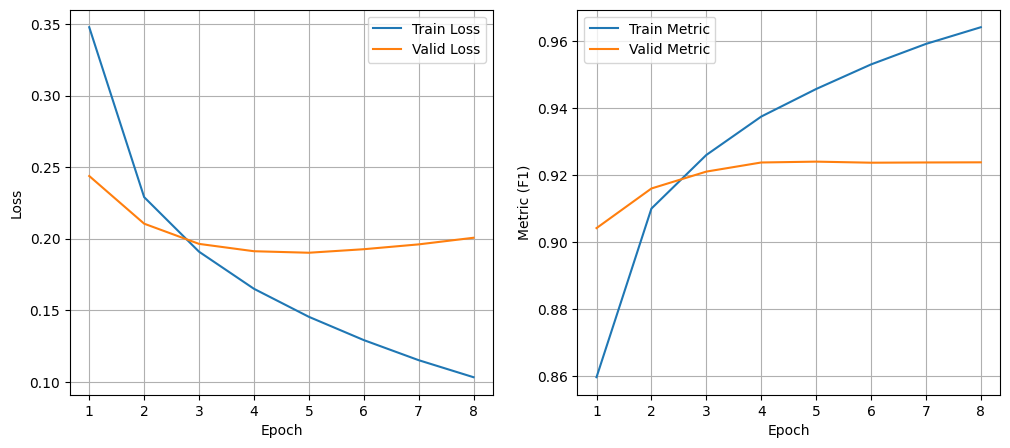

In [35]:
# 1. Подготовка TF-IDF признаков

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')

# Обучаем TF-IDF на всех тренировочных текстах
tfidf.fit(df_train_expanded['text'])

X_train_tfidf = tfidf.transform(df_train_expanded['text'])  
X_valid_tfidf = tfidf.transform(valid_df['text'])


# Метки
y_train = np.array(df_train_expanded['labels_list'].to_list(), dtype=np.float32)
y_valid = np.array(valid_df['labels_list'].to_list(), dtype=np.float32)

# 2. Dataset и DataLoader для PyTorch

class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze()  
        y = self.y[idx]
        return {
            'input': torch.tensor(x, dtype=torch.float32),
            'target': torch.tensor(y, dtype=torch.float32)
        }

train_dataset = TfidfDataset(X_train_tfidf, y_train)
valid_dataset = TfidfDataset(X_valid_tfidf, y_valid)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

# 3. Простая нейронная сеть для TF-IDF (2 слоя)

class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNN(input_dim=X_train_tfidf.shape[1]).to(device)

# 4. Лосс и метрика

criterion_dict = {
    'train': nn.BCEWithLogitsLoss(),
    'valid': nn.BCEWithLogitsLoss()
}

def f1_score_multilabel(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

metric_dict = {
    'train': f1_score_multilabel,
    'valid': f1_score_multilabel
}

# 5. Оптимайзер и шедулер

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# 6. Запуск обучения

model = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion_dict=criterion_dict,
    metric_dict=metric_dict,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    switch_epoch=None,
    save_path='best_tfidf_model.pth',
    early_stopping_patience=3,
    warmup_steps=0
)
